# Ziro Shot Learning

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader,Subset
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision import datasets, transforms, models

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
input_dim = 512  # خروجی ResNet18 feature extractor
latent_dim = 64
batch_size = 128
epochs = 20
num_seen_classes = 8
num_unseen_classes = 2

In [4]:
all_classes = list(range(10))
random.shuffle(all_classes)
seen_classes = all_classes[:num_seen_classes]
unseen_classes = all_classes[num_seen_classes:]

print('Seen', seen_classes, 'Unseen', unseen_classes)

Seen [9, 6, 4, 3, 0, 2, 1, 8] Unseen [5, 7]


In [5]:
def filter_by_class(dataset, classes):
    indices = [i for i, (_, label) in enumerate(dataset) if label in classes]
    return Subset(dataset, indices)

train_seen = filter_by_class(trainset, seen_classes)
test_unseen = filter_by_class(testset, unseen_classes)

train_loader = DataLoader(train_seen, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_unseen, batch_size=batch_size, shuffle=False)

In [6]:
classes = train_loader.dataset.dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

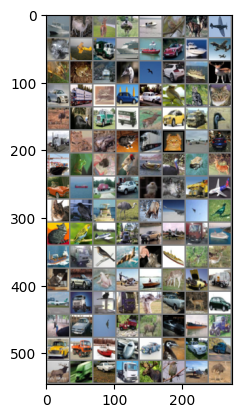

ship  deer  deer  bird  ship  bird  deer  airplane cat   airplane truck ship  ship  automobile ship  airplane deer  frog  ship  bird  bird  automobile ship  deer  automobile truck cat   automobile automobile bird  cat   cat   bird  bird  truck truck deer  automobile truck bird  truck cat   frog  cat   truck cat   airplane automobile ship  frog  cat   bird  ship  bird  frog  deer  automobile ship  truck automobile bird  cat   truck airplane cat   bird  ship  bird  deer  airplane airplane bird  cat   bird  airplane truck automobile airplane truck ship  ship  truck bird  airplane cat   ship  deer  deer  cat   automobile frog  airplane ship  deer  automobile truck airplane truck cat   truck bird  automobile deer  automobile bird  automobile airplane truck deer  automobile ship  truck automobile truck ship  airplane automobile bird  automobile truck deer  truck automobile truck deer  bird  airplane bird 


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
resnet = models.resnet18(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # حذف لایه‌ی آخر (FC)
resnet.to(device)
resnet.eval()

def extract_features(images):
    with torch.no_grad():
        feats = resnet(images).view(images.size(0), -1)
    return feats

d:\Pouya Git\advance_computer_vision\ZSL\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Pouya Git\advance_computer_vision\ZSL\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
class VAE_lite(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE_lite, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.fc2 = nn.Linear(latent_dim, 256)
        self.fc3 = nn.Linear(256, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return self.fc3(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [11]:
def vae_lite_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

vae = VAE_lite(input_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [13]:
print("Training VAE on seen class features...")
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        feats = extract_features(imgs)

        recon, mu, logvar = vae(feats)
        loss = vae_lite_loss(recon, feats, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}")

Training VAE on seen class features...
Epoch 1, Loss: 4509568.86
Epoch 2, Loss: 3205152.54
Epoch 3, Loss: 2848439.09
Epoch 4, Loss: 2688391.47
Epoch 5, Loss: 2614070.02
Epoch 6, Loss: 2571333.97
Epoch 7, Loss: 2543862.62
Epoch 8, Loss: 2525489.39
Epoch 9, Loss: 2511177.49
Epoch 10, Loss: 2499598.79
Epoch 11, Loss: 2489241.11
Epoch 12, Loss: 2482807.81
Epoch 13, Loss: 2475330.52
Epoch 14, Loss: 2470391.85
Epoch 15, Loss: 2465112.29
Epoch 16, Loss: 2460792.11
Epoch 17, Loss: 2456831.94
Epoch 18, Loss: 2452847.81
Epoch 19, Loss: 2449824.86
Epoch 20, Loss: 2448381.43


In [14]:
print("Generating synthetic features for unseen classes...")
vae.eval()
synthetic_features = []
synthetic_labels = []

samples_per_class = 200

for cls in unseen_classes:
    for _ in range(samples_per_class):
        z = torch.randn(1, latent_dim).to(device)
        fake_feat = vae.decode(z).detach().cpu()
        synthetic_features.append(fake_feat)
        synthetic_labels.append(cls)

synthetic_features = torch.cat(synthetic_features, dim=0)
synthetic_labels = torch.tensor(synthetic_labels)

Generating synthetic features for unseen classes...


In [15]:
print("Training classifier on synthetic features...")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=1000)
clf.fit(synthetic_features.numpy(), synthetic_labels.numpy())

Training classifier on synthetic features...


LogisticRegression(max_iter=1000)

In [16]:
print("Evaluating on real unseen class features...")
real_feats = []
real_labels = []

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    feats = extract_features(imgs).cpu()
    real_feats.append(feats)
    real_labels.append(labels)

real_feats = torch.cat(real_feats, dim=0)
real_labels = torch.cat(real_labels, dim=0)

preds = clf.predict(real_feats.numpy())
acc = accuracy_score(real_labels.numpy(), preds)

print(f"Zero-Shot Accuracy on Unseen Classes: {acc * 100:.2f}%")

Evaluating on real unseen class features...
Zero-Shot Accuracy on Unseen Classes: 47.75%
